### Step 1: ライブラリの読み込みとパス定義

画像からスコアを予測するCNNモデルを構築するために、必要なライブラリを読み込み、データのパスを定義します。

- `torch`：PyTorch本体
- `torchvision.transforms`：画像前処理用
- `PIL.Image`：画像の読み込み
- `pandas`：CSVデータの操作
- `Pathlib`：パス操作
- `matplotlib.pyplot`：結果の可視化
- `train_test_split`：訓練・検証データの分割

また、使用するデバイス（CUDA, MPS, CPU）を自動で判定します。

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# パス定義
DATA_DIR = Path('../../data/circle-text')
CSV_PATH = DATA_DIR / 'metadata.csv'
IMG_DIR = DATA_DIR / 'images'

# デバイス設定（CUDA > MPS > CPU）
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')

print("Using device:", device)

Using device: mps


### Step 2: DatasetクラスとTransformの定義

画像とスコア（連続値）をペアで読み込むカスタムDatasetクラス `ScoreImageDataset` を定義します。

- 各画像ファイルは `metadata.csv` の `id` 列から `<id>.png` として読み込まれます。
- スコア列（`score`）は float 型で正規化済み（0〜1）と仮定します。
- transform処理では、画像サイズの違いを吸収するために `256x256` にリサイズし、テンソル化・正規化（-1〜1）を行います。

また、正方形ではない画像にも対応できるように、アスペクト比を保持したリサイズに変更することも可能です。

In [12]:
class ScoreImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # ファイル名の先頭に 'img_' を追加して対応
        img_path = self.img_dir / f"img_{int(row['id'])}.png"

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        score = torch.tensor(float(row['score']), dtype=torch.float32)
        return image, score

# TransformはそのままでOK
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### Step 3: CNNモデルの定義（回帰タスク）

入力画像から好みスコア（0〜1）を回帰的に予測するための、シンプルなCNNモデルを定義します。

- 畳み込み層（Conv2D）とプーリング（MaxPool）を数層積み重ね、
- 最後に全結合層（Linear）を通して1つの出力値（score）を出力します。
- 活性化関数にはReLUを使用し、最終層には活性化を使いません（回帰のため）。

将来的には `sigmoid` で0〜1に制限することも可能ですが、ここではモデル自身が適切な範囲に学習することを期待します。

In [13]:
class SimpleCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (B, 3, 256, 256) → (B, 16, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (B, 16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (B, 32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (B, 64, 32, 32)

            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # 出力1ノード（スコア）
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # 出力 shape: (B)

### Step 4: 学習準備（損失関数・最適化・データローダ）

モデルを学習するための損失関数とオプティマイザを定義します。

- **損失関数（loss）**には、回帰タスクでよく使われる `MSELoss（平均二乗誤差）` を使用します。
- **最適化アルゴリズム**には `Adam` を使い、学習率は `1e-4` に設定します。
- データセットは `train_test_split` を用いて8:2に分割し、`DataLoader` でミニバッチ処理できるようにします。

この段階でモデルとデータの準備が整い、学習ループへ進むことができます。

In [14]:
# データの読み込み
full_dataset = ScoreImageDataset(CSV_PATH, IMG_DIR, transform=transform)

# 訓練・検証に分割（8:2）
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, random_state=42
)
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# モデル定義
model = SimpleCNNRegressor().to(device)

# 損失関数 & 最適化
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Step 5: 学習ループの実装

ここでは、CNNモデルを学習するメイントレーニングループを定義します。

- 各エポックごとに訓練（train）と検証（val）の2フェーズを行います。
- ミニバッチごとに損失（MSE）を計算し、訓練では誤差逆伝播とパラメータの更新を行います。
- `tqdm` を使って進捗バーを表示しつつ、エポックごとの平均ロスを記録します。

最後にエポックごとの loss を `train_losses` / `val_losses` に格納し、学習の様子を可視化できるようにします。

In [15]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]"):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # 検証フェーズ
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [val]"):
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * images.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

    return train_losses, val_losses

### Step 6: 学習の実行と wandb ログの追加


このステップでは、関数化せずにセルに直接学習ループを記述して学習を実行します。

- `wandb.init()` でログ記録を開始し、エポックごとに `train_loss` と `val_loss` を `wandb.log()` で送信します。
- 損失計算には `MSELoss` を使用し、モデルの評価モード (`model.eval()`) を用いて検証します。
- 最終的に `wandb.finish()` でセッションを終了します。

この形式は、試行錯誤や確認がしやすく、デバッグ・実験には非常に適しています。

In [18]:
import wandb

wandb.init(project="image2score", name="cnn_regression_run")

EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]"):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * images.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # wandb ログ
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

wandb.finish()

Epoch 1/10 [val]: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch 1: Train Loss=0.0174, Val Loss=0.0128


Epoch 2/10 [val]: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch 2: Train Loss=0.0094, Val Loss=0.0091


Epoch 3/10 [val]: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch 3: Train Loss=0.0080, Val Loss=0.0070


Epoch 4/10 [val]: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch 4: Train Loss=0.0053, Val Loss=0.0055


Epoch 5/10 [val]: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch 5: Train Loss=0.0046, Val Loss=0.0052


Epoch 6/10 [val]: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch 6: Train Loss=0.0045, Val Loss=0.0039


Epoch 7/10 [val]: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 7: Train Loss=0.0035, Val Loss=0.0033


Epoch 8/10 [val]: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch 8: Train Loss=0.0028, Val Loss=0.0026


Epoch 9/10 [val]: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch 9: Train Loss=0.0022, Val Loss=0.0028


Epoch 10/10 [val]: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch 10: Train Loss=0.0017, Val Loss=0.0019


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▄▃▂▂▂▁▁▁
val_loss,█▆▄▃▃▂▂▁▂▁
epoch,10
train_loss,0.00173
val_loss,0.0019


### Step 8: 検証データからの予測と正解の表示

検証用の DataLoader から数枚の画像を取り出し、モデルによる予測スコアと実際のスコアを並べて表示します。

- `model.eval()` モードで予測を行い、
- 元画像は `un-normalize` して表示用に変換します。
- 結果は `matplotlib` を用いて並べて可視化します。

このステップでは、モデルがどの程度「好みスコア」を捉えているかの直感的な理解を助けます。

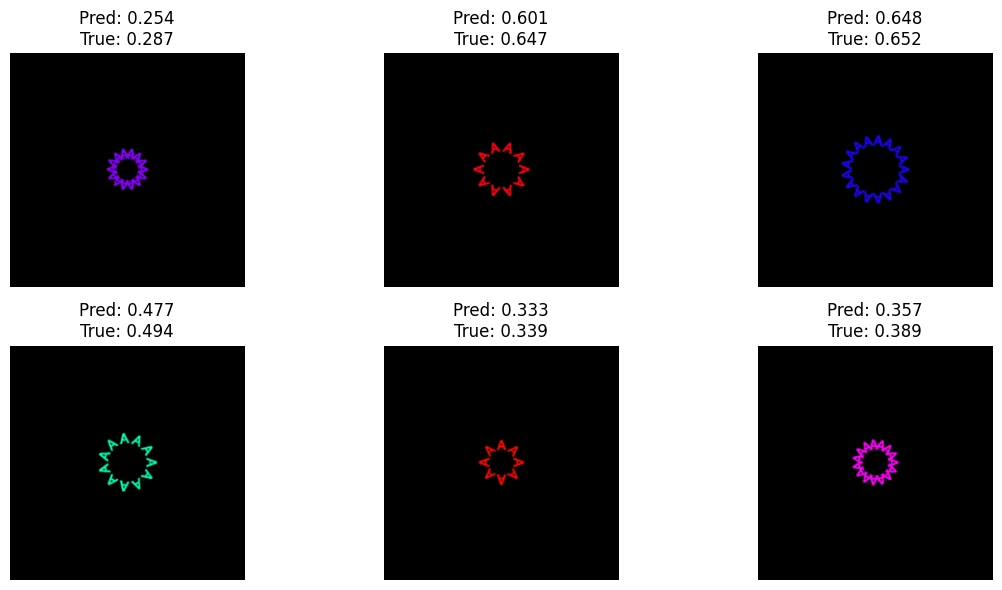

In [19]:
# モデルを評価モードに
model.eval()

# 検証データから数件取り出して表示（例：6枚）
n_samples = 6
samples = []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        preds = model(images)
        samples = list(zip(images.cpu(), preds.cpu(), targets))[:n_samples]
        break  # 最初のバッチだけでOK

# 逆正規化関数（[-1, 1] → [0, 1]）
def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

# 結果を並べて表示
plt.figure(figsize=(12, 6))
for i, (img, pred, true) in enumerate(samples):
    plt.subplot(2, 3, i+1)
    img_np = unnormalize(img).permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Pred: {pred.item():.3f}\nTrue: {true.item():.3f}")

plt.tight_layout()
plt.show()

### Step 9: 散布図による予測性能の可視化

検証データ全体に対してモデルによるスコア予測を行い、

- 横軸：正解スコア（ground truth）
- 縦軸：予測スコア（predicted）

として散布図を描画することで、モデルの回帰性能を視覚的に確認します。

理想的な予測であれば、点は対角線（y=x）上に並びます。

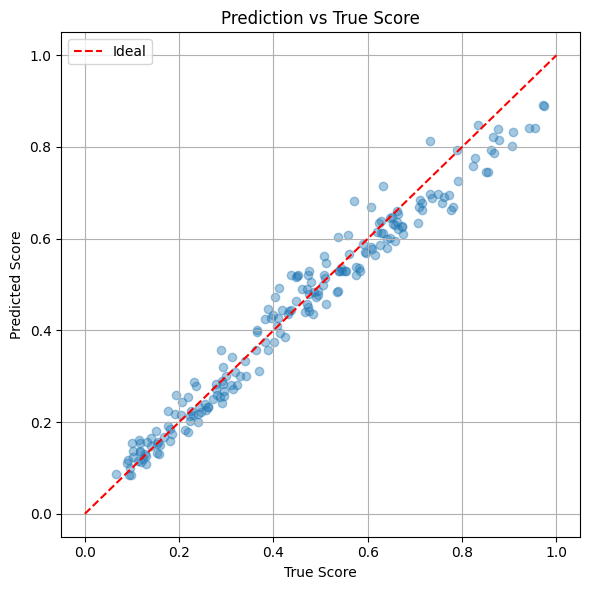

In [20]:
# 検証データ全体に対する予測を収集
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        all_preds.extend(outputs)
        all_targets.extend(targets.numpy())

# 散布図を描画
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--', label="Ideal")  # 対角線
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Prediction vs True Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()